Loading diabetes dataset
Baseline: 0.64
Our test-score: 0.75


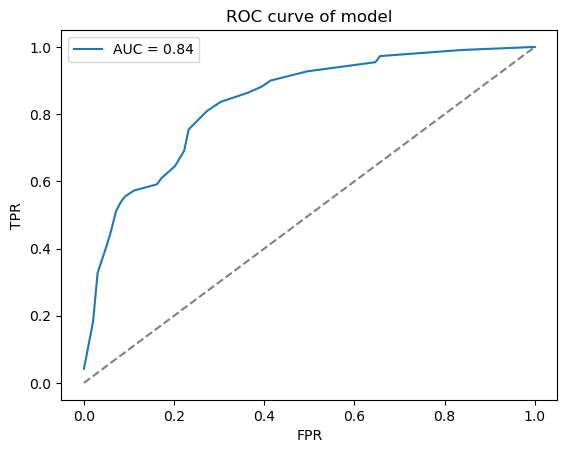

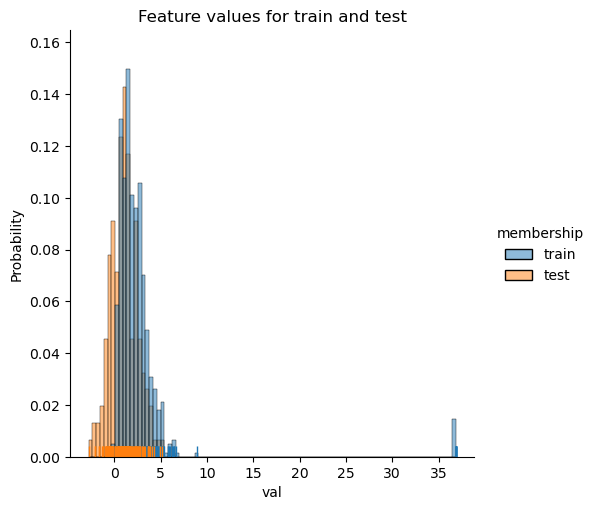

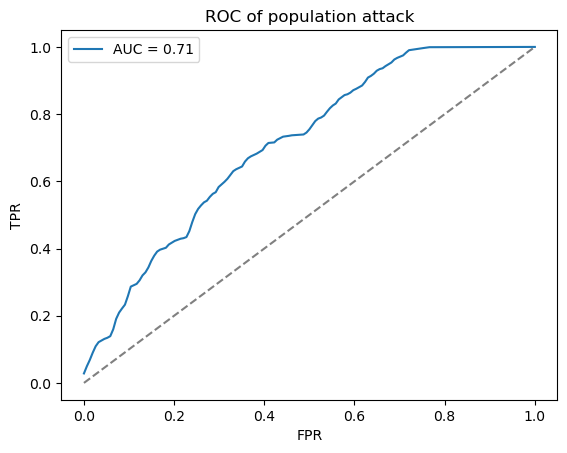

In [8]:
%run 3-population-attack.ipynb

## Protect against leakage

Now that we know how much that we're leaking privacy-wise, we can apply the `Opacus / DiffPrivLib` library
to our model and see how the ROC curve flattens.

In [9]:
from diffprivlib.models import RandomForestClassifier as dp_RFC

rfc_dp = dp_RFC(
    n_estimators=80,
    max_depth=10,
    random_state=42,
    epsilon=1e100,
    bounds=(np.min(X_train, axis=0), np.max(X_train, axis=0)),
    classes=np.unique(y_train),
)

target_model = rfc_dp.fit(X_train, y_train)
# The classifier's accuracy vs. random baseline. We are doing a bit better than the baseline.
print(f"Baseline: {max(y_test.mean(), 1 - y_test.mean()):0.2f}")
print(f"Our test-score: {target_model.score(X_test, y_test):0.2f}" )

Baseline: 0.64
Our test-score: 0.78


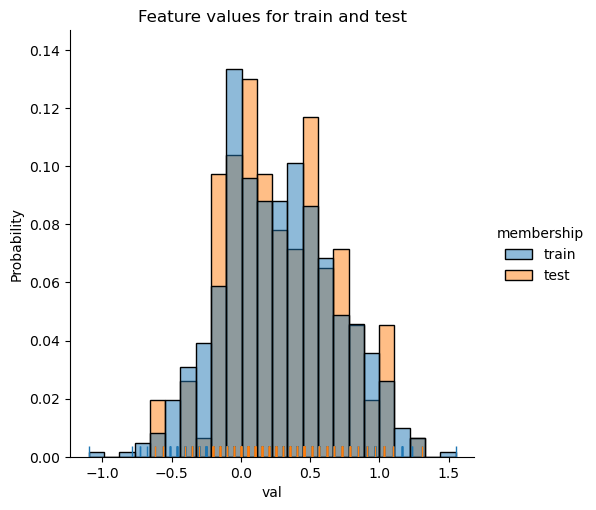

In [10]:
# Extract the features for the membership inference attack.
logits_train = logits(target_model, X_train, y_train)
logits_test = logits(target_model, X_test, y_test)

# Visualize the features. If it is possible to tell train data from test data, then
# our model is vulnerable to membership inference.
visualize_vals(logits_train, logits_test)

<Axes: xlabel='FPR', ylabel='TPR'>

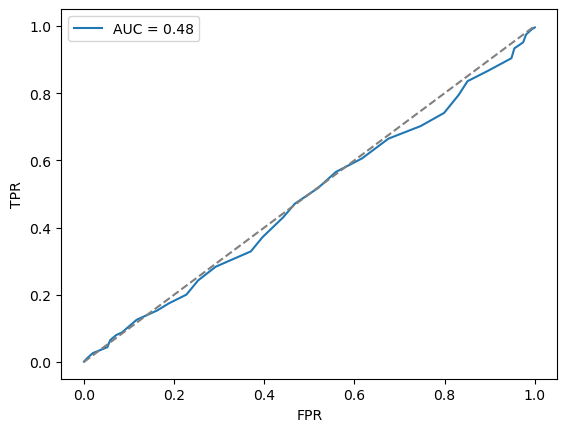

In [11]:
# In principle, we do not even need to implement the threshold selection in `measure_membership_vulnerability`.
# Here I am just using roc_curve from scikit-learn.
fpr, tpr, _ = roc_curve(membership_labels, np.concatenate([logits_train, logits_test]))
roc_auc = auc(fpr, tpr)

roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})

sns.lineplot(x='FPR', y='TPR', data=roc_df, label=f"AUC = {roc_auc:0.2f}", errorbar=None)
sns.lineplot(x=[0, 1], y=[0, 1], color='grey', linestyle='--')

## Measuring True Privacy Leakage

In [13]:
def compute_feature_func(func, models):
    return np.array([func(model) for model in models])

In [15]:
num_examples_to_attack = 50
num_ref_models = 10

# Collect some arbitrary target examples to attack.
examples_to_attack = []

# ...half from the training data.
for index in X_train.index[:num_examples_to_attack // 2]:
    examples_to_attack.append((index, X_train.loc[index], y_train.loc[index], 1))
    
# ...half from the test data.
for index in X_test.index[:num_examples_to_attack // 2]:
    examples_to_attack.append((index, X_test.loc[index], y_test.loc[index], 0))

result = []

# Now run the re-training attacks!
for index, x, y, is_member in tqdm(examples_to_attack):
    # First, train a bunch of models without the target example (if it is in fact part of the training data)
    out_models = []
    for seed in range(num_ref_models):
        ref_model = train_model(
            X_train.drop(index=[index], errors="ignore"),
            y_train.drop(index=[index], errors="ignore"),
            seed=seed
        )
        out_models.append(ref_model)
    
    # Compute the attack features.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        preds_in = compute_feature_func(lambda model: model.predict_proba([x])[0], [target_model])
        preds_out = compute_feature_func(lambda model: model.predict_proba([x])[0], out_models)
    
    logit_in = logit_scale(y, preds_in)[0]
    logits_out = logit_scale(y, preds_out)
    
    # Next, we run a parametric test. We assume that "out" logits are Gaussian-distributed, 
    # so compute their mean and variance.
    logits_out_mean = np.mean(logits_out)
    logits_out_var = np.var(logits_out)
    
    # The parametric test is computing the probability that the "out" logits are less than "in" logit,
    # which means that we predict the target record as a member:
    # 
    #   Pr[logit_out <= logit_in], where logit_out ~ Normal(mean, var) with mean and var
    #   estimated from reference models.
    #
    # See https://arxiv.org/abs/2112.03570, Eq. (4)
    prob = stats.norm(logits_out_mean, logits_out_var).cdf(logit_in) 
    
    result.append(dict(
        target_index=index,
        is_member=is_member,
        prob=prob,
    ))

100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.37s/it]


<Axes: xlabel='FPR', ylabel='TPR'>

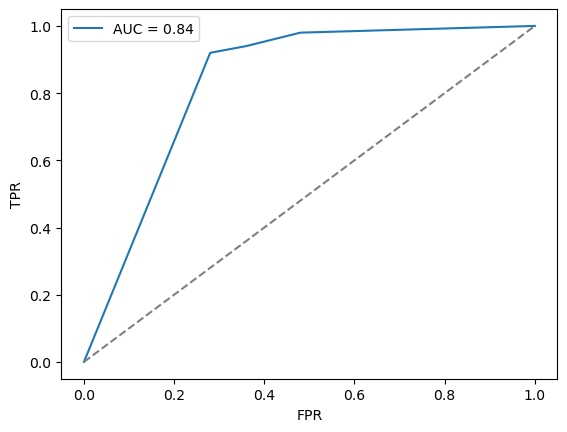

In [17]:
fpr, tpr, _ = roc_curve(pd.DataFrame(result).is_member, pd.DataFrame(result).prob)
roc_auc = auc(fpr, tpr)

roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})

sns.lineplot(x='FPR', y='TPR', data=roc_df, label=f"AUC = {roc_auc:0.2f}", errorbar=None)
sns.lineplot(x=[0, 1], y=[0, 1], color='grey', linestyle='--')